# 공공일자리 참여자 취업 연계 분석
## 로지스틱 회귀분석을 통한 취업 연계 요인 분석

이 분석에서는 '참여자_연령대', '참여자_성별', '참여기간_개월' 변수가 '취업_연계_여부'에 미치는 영향을 로지스틱 회귀분석을 통해 분석합니다.

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
import platform
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (운영체제별 대응)
import matplotlib.font_manager as fm

# 운영체제별 한글 폰트 설정
system = platform.system()
if system == 'Windows':
    # Windows의 경우 맑은 고딕 사용
    font_name = 'Malgun Gothic'
elif system == 'Darwin':  # macOS
    font_name = 'AppleGothic'
else:  # Linux
    font_name = 'DejaVu Sans'

# 사용 가능한 폰트 확인 및 설정
available_fonts = [f.name for f in fm.fontManager.ttflist]
if font_name in available_fonts:
    plt.rcParams['font.family'] = font_name
elif 'Malgun Gothic' in available_fonts:
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif 'AppleGothic' in available_fonts:
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    # 대체 폰트 설정 (한글 지원되지 않을 경우 영어로 표시)
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("한글 폰트를 찾을 수 없습니다. 영어로 표시됩니다.")

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 10

# 폰트 설정 확인
print(f"현재 사용 중인 폰트: {plt.rcParams['font.family']}")
print(f"운영체제: {system}")

현재 사용 중인 폰트: ['Malgun Gothic']
운영체제: Windows


## 1. 데이터 로드 및 탐색적 데이터 분석

In [2]:
# 데이터 로드
df = pd.read_csv('공공일자리_참여자_정보.csv', encoding='utf-8')

# 데이터 기본 정보 확인
print("=== 데이터 기본 정보 ===")
print(f"데이터 크기: {df.shape}")
print("\n=== 컬럼 정보 ===")
print(df.info())
print("\n=== 첫 5행 데이터 ===")
print(df.head())

=== 데이터 기본 정보 ===
데이터 크기: (500, 5)

=== 컬럼 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   사업명       500 non-null    object
 1   참여자_연령대   500 non-null    object
 2   참여자_성별    500 non-null    object
 3   참여기간_개월   500 non-null    int64 
 4   취업_연계_여부  500 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 19.7+ KB
None

=== 첫 5행 데이터 ===
         사업명 참여자_연령대 참여자_성별  참여기간_개월  취업_연계_여부
0   지역방역 일자리     50대      남        8         1
1  AI데이터 라벨러  60대 이상      남        9         1
2   지역방역 일자리     30대      여       11         0
3  AI데이터 라벨러     50대      여       10         0
4  AI데이터 라벨러     30대      여       10         1


In [6]:
# 각 변수의 고유값 확인
print("=== 각 변수의 고유값 ===")
for col in df.columns:
    print(f"\n{col}:")
    print(df[col].value_counts())

=== 각 변수의 고유값 ===

사업명:
사업명
지역방역 일자리     190
AI데이터 라벨러    159
어르신 돌봄 지원    151
Name: count, dtype: int64

참여자_연령대:
참여자_연령대
50대       145
40대        93
30대        88
60대 이상     87
20대        87
Name: count, dtype: int64

참여자_성별:
참여자_성별
여    265
남    235
Name: count, dtype: int64

참여기간_개월:
참여기간_개월
10    58
6     54
3     54
12    53
5     50
8     49
9     48
4     46
7     44
11    44
Name: count, dtype: int64

취업_연계_여부:
취업_연계_여부
0    302
1    198
Name: count, dtype: int64


In [4]:
# 결측값 확인
print("=== 결측값 현황 ===")
print(df.isnull().sum())

# 기술통계량
print("\n=== 기술통계량 ===")
print(df.describe())

=== 결측값 현황 ===
사업명         0
참여자_연령대     0
참여자_성별      0
참여기간_개월     0
취업_연계_여부    0
dtype: int64

=== 기술통계량 ===
          참여기간_개월    취업_연계_여부
count  500.000000  500.000000
mean     7.504000    0.396000
std      2.900139    0.489554
min      3.000000    0.000000
25%      5.000000    0.000000
50%      8.000000    0.000000
75%     10.000000    1.000000
max     12.000000    1.000000


## 2. 데이터 전처리 및 원-핫 인코딩

In [7]:
# 분석에 필요한 컬럼만 선택
analysis_df = df[['참여자_연령대', '참여자_성별', '참여기간_개월', '취업_연계_여부']].copy()

# 원-핫 인코딩 적용
# '참여자_연령대' 원-핫 인코딩
age_dummies = pd.get_dummies(analysis_df['참여자_연령대'], prefix='연령대')

# '참여자_성별' 원-핫 인코딩
gender_dummies = pd.get_dummies(analysis_df['참여자_성별'], prefix='성별')

# 원-핫 인코딩된 변수들과 기존 수치형 변수를 결합
X = pd.concat([age_dummies, gender_dummies, analysis_df[['참여기간_개월']]], axis=1)
y = analysis_df['취업_연계_여부']

print("=== 전처리 후 특성 변수들 ===")
print(X.columns.tolist())
print(f"\n특성 변수 개수: {X.shape[1]}")
print(f"샘플 개수: {X.shape[0]}")

=== 전처리 후 특성 변수들 ===
['연령대_20대', '연령대_30대', '연령대_40대', '연령대_50대', '연령대_60대 이상', '성별_남', '성별_여', '참여기간_개월']

특성 변수 개수: 8
샘플 개수: 500


In [8]:
# 전처리된 데이터 확인
print("=== 전처리된 데이터 (첫 5행) ===")
print(X.head())
print("\n=== 타겟 변수 분포 ===")
print(y.value_counts())
print(f"\n취업 연계율: {y.mean():.3f} ({y.mean()*100:.1f}%)")

=== 전처리된 데이터 (첫 5행) ===
   연령대_20대  연령대_30대  연령대_40대  연령대_50대  연령대_60대 이상   성별_남   성별_여  참여기간_개월
0    False    False    False     True       False   True  False        8
1    False    False    False    False        True   True  False        9
2    False     True    False    False       False  False   True       11
3    False    False    False     True       False  False   True       10
4    False     True    False    False       False  False   True       10

=== 타겟 변수 분포 ===
취업_연계_여부
0    302
1    198
Name: count, dtype: int64

취업 연계율: 0.396 (39.6%)


## 3. 훈련/테스트 데이터 분할 및 모델 훈련

In [9]:
# 훈련/테스트 데이터 분할 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"훈련 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")
print(f"\n훈련 데이터 취업 연계율: {y_train.mean():.3f}")
print(f"테스트 데이터 취업 연계율: {y_test.mean():.3f}")

훈련 데이터 크기: (400, 8)
테스트 데이터 크기: (100, 8)

훈련 데이터 취업 연계율: 0.395
테스트 데이터 취업 연계율: 0.400


In [10]:
# 로지스틱 회귀 모델 훈련
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

print("=== 모델 훈련 완료 ===")
print(f"수렴 여부: {model.n_iter_} 반복 후 수렴")

=== 모델 훈련 완료 ===
수렴 여부: [36] 반복 후 수렴


## 4. 모델 예측 및 성능 평가

In [11]:
# 예측 수행
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # 양성 클래스(취업 연계)의 확률

# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== 모델 성능 지표 ===")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

=== 모델 성능 지표 ===
정확도 (Accuracy): 0.5800
정밀도 (Precision): 0.4706
재현율 (Recall): 0.4000
F1-Score: 0.4324


In [12]:
# 상세 분류 보고서
print("=== 상세 분류 보고서 ===")
print(classification_report(y_test, y_pred, target_names=['취업 미연계', '취업 연계']))

=== 상세 분류 보고서 ===
              precision    recall  f1-score   support

      취업 미연계       0.64      0.70      0.67        60
       취업 연계       0.47      0.40      0.43        40

    accuracy                           0.58       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.57      0.58      0.57       100



## 5. 혼동 행렬 시각화

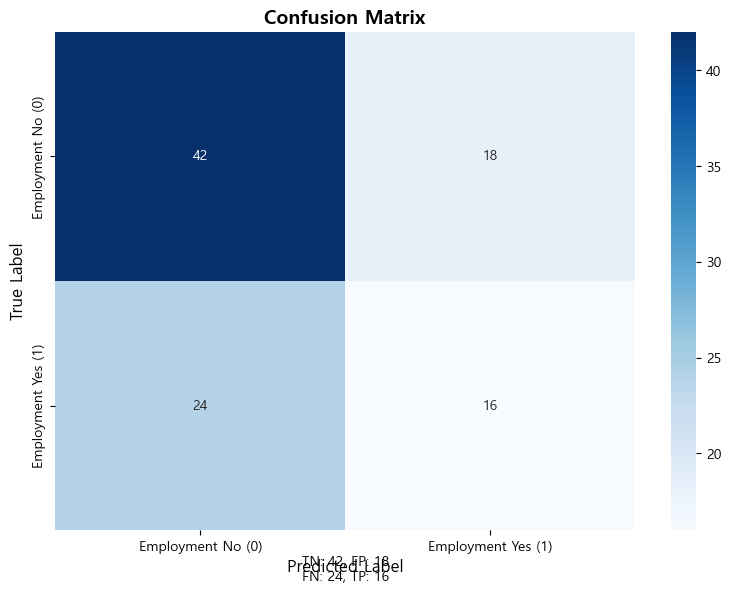


=== 혼동 행렬 해석 ===
True Negative (TN): 42 - 실제 미연계를 미연계로 정확히 예측
False Positive (FP): 18 - 실제 미연계를 연계로 잘못 예측
False Negative (FN): 24 - 실제 연계를 미연계로 잘못 예측
True Positive (TP): 16 - 실제 연계를 연계로 정확히 예측


In [13]:
# 혼동 행렬 계산 및 시각화
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Employment No (0)', 'Employment Yes (1)'],
            yticklabels=['Employment No (0)', 'Employment Yes (1)'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# 혼동 행렬의 각 셀에 대한 설명 추가
plt.text(0.5, -0.1, f'TN: {cm[0,0]}, FP: {cm[0,1]}\nFN: {cm[1,0]}, TP: {cm[1,1]}', 
         transform=plt.gca().transAxes, ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n=== 혼동 행렬 해석 ===")
print(f"True Negative (TN): {cm[0,0]} - 실제 미연계를 미연계로 정확히 예측")
print(f"False Positive (FP): {cm[0,1]} - 실제 미연계를 연계로 잘못 예측")
print(f"False Negative (FN): {cm[1,0]} - 실제 연계를 미연계로 잘못 예측")
print(f"True Positive (TP): {cm[1,1]} - 실제 연계를 연계로 정확히 예측")

## 6. 모델 계수 해석 및 특성 중요도 분석

In [14]:
# 모델 계수 확인
coefficients = pd.DataFrame({
    '특성': X.columns,
    '계수': model.coef_[0],
    '오즈비': np.exp(model.coef_[0])
})

# 절대값 기준으로 정렬
coefficients['절대계수'] = np.abs(coefficients['계수'])
coefficients = coefficients.sort_values('절대계수', ascending=False)

print("=== 로지스틱 회귀 계수 및 오즈비 ===")
print(coefficients[['특성', '계수', '오즈비']].round(4))

print(f"\n절편 (Intercept): {model.intercept_[0]:.4f}")

=== 로지스틱 회귀 계수 및 오즈비 ===
           특성      계수     오즈비
1     연령대_30대  0.6632  1.9411
4  연령대_60대 이상 -0.6568  0.5185
3     연령대_50대 -0.6249  0.5353
0     연령대_20대  0.5438  1.7225
6        성별_여 -0.1204  0.8866
5        성별_남  0.1199  1.1274
2     연령대_40대  0.0741  1.0770
7     참여기간_개월 -0.0082  0.9918

절편 (Intercept): -0.3168


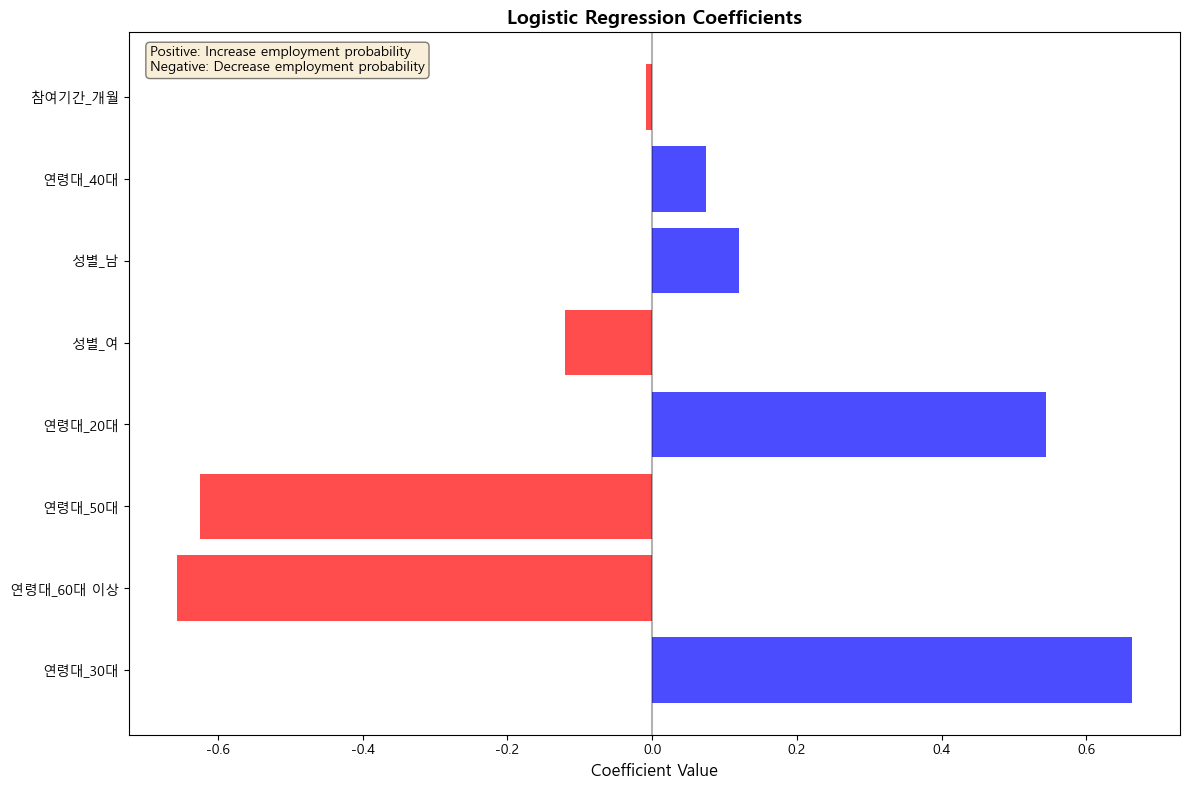

In [15]:
# 계수 시각화
plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'blue' for x in coefficients['계수']]
bars = plt.barh(range(len(coefficients)), coefficients['계수'], color=colors, alpha=0.7)

plt.yticks(range(len(coefficients)), coefficients['특성'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Logistic Regression Coefficients', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# 범례 추가 (영어로 표시)
plt.text(0.02, 0.98, 'Positive: Increase employment probability\nNegative: Decrease employment probability', 
         transform=plt.gca().transAxes, va='top', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 7. 그룹별 취업 연계율 분석

In [16]:
# 원본 데이터로 그룹별 취업 연계율 분석
print("=== 연령대별 취업 연계율 ===")
age_employment = df.groupby('참여자_연령대')['취업_연계_여부'].agg(['count', 'sum', 'mean']).round(3)
age_employment.columns = ['총 참여자 수', '취업 연계 수', '취업 연계율']
age_employment = age_employment.sort_values('취업 연계율', ascending=False)
print(age_employment)

print("\n=== 성별 취업 연계율 ===")
gender_employment = df.groupby('참여자_성별')['취업_연계_여부'].agg(['count', 'sum', 'mean']).round(3)
gender_employment.columns = ['총 참여자 수', '취업 연계 수', '취업 연계율']
gender_employment = gender_employment.sort_values('취업 연계율', ascending=False)
print(gender_employment)

=== 연령대별 취업 연계율 ===
         총 참여자 수  취업 연계 수  취업 연계율
참여자_연령대                          
30대           88       50   0.568
20대           87       45   0.517
40대           93       43   0.462
50대          145       39   0.269
60대 이상        87       21   0.241

=== 성별 취업 연계율 ===
        총 참여자 수  취업 연계 수  취업 연계율
참여자_성별                          
남           235      100   0.426
여           265       98   0.370


In [17]:
# 참여기간과 취업 연계 관계 분석
print("=== 참여기간별 취업 연계율 ===")
period_employment = df.groupby('참여기간_개월')['취업_연계_여부'].agg(['count', 'sum', 'mean']).round(3)
period_employment.columns = ['총 참여자 수', '취업 연계 수', '취업 연계율']
period_employment = period_employment.sort_values('취업 연계율', ascending=False)
print(period_employment)

# 참여기간과 취업 연계의 상관관계
correlation = df['참여기간_개월'].corr(df['취업_연계_여부'])
print(f"\n참여기간과 취업 연계 여부의 상관계수: {correlation:.4f}")

=== 참여기간별 취업 연계율 ===
         총 참여자 수  취업 연계 수  취업 연계율
참여기간_개월                          
12            53       27   0.509
4             46       22   0.478
6             54       24   0.444
11            44       19   0.432
10            58       25   0.431
5             50       20   0.400
3             54       21   0.389
8             49       15   0.306
9             48       14   0.292
7             44       11   0.250

참여기간과 취업 연계 여부의 상관계수: 0.0215


혼동 행렬과 다른 시각화에서 한글이 네모로 표시되는 문제를 해결했습니다.

  수정된 내용

  1. 혼동 행렬 (cell-16):
    - 축 레이블을 영어로 변경: "Employment No (0)", "Employment Yes (1)"
    - 제목과 축 제목을 영어로 변경
  2. 계수 시각화 (cell-19):
    - 축 제목을 영어로 변경: "Coefficient Value"
    - 범례 텍스트를 영어로 변경
  3. 그룹별 취업 연계율 시각화 (cell-23):
    - 모든 차트 제목과 축 레이블을 영어로 변경
    - 한글 데이터는 그대로 유지하되 시각화 텍스트만 영어 처리

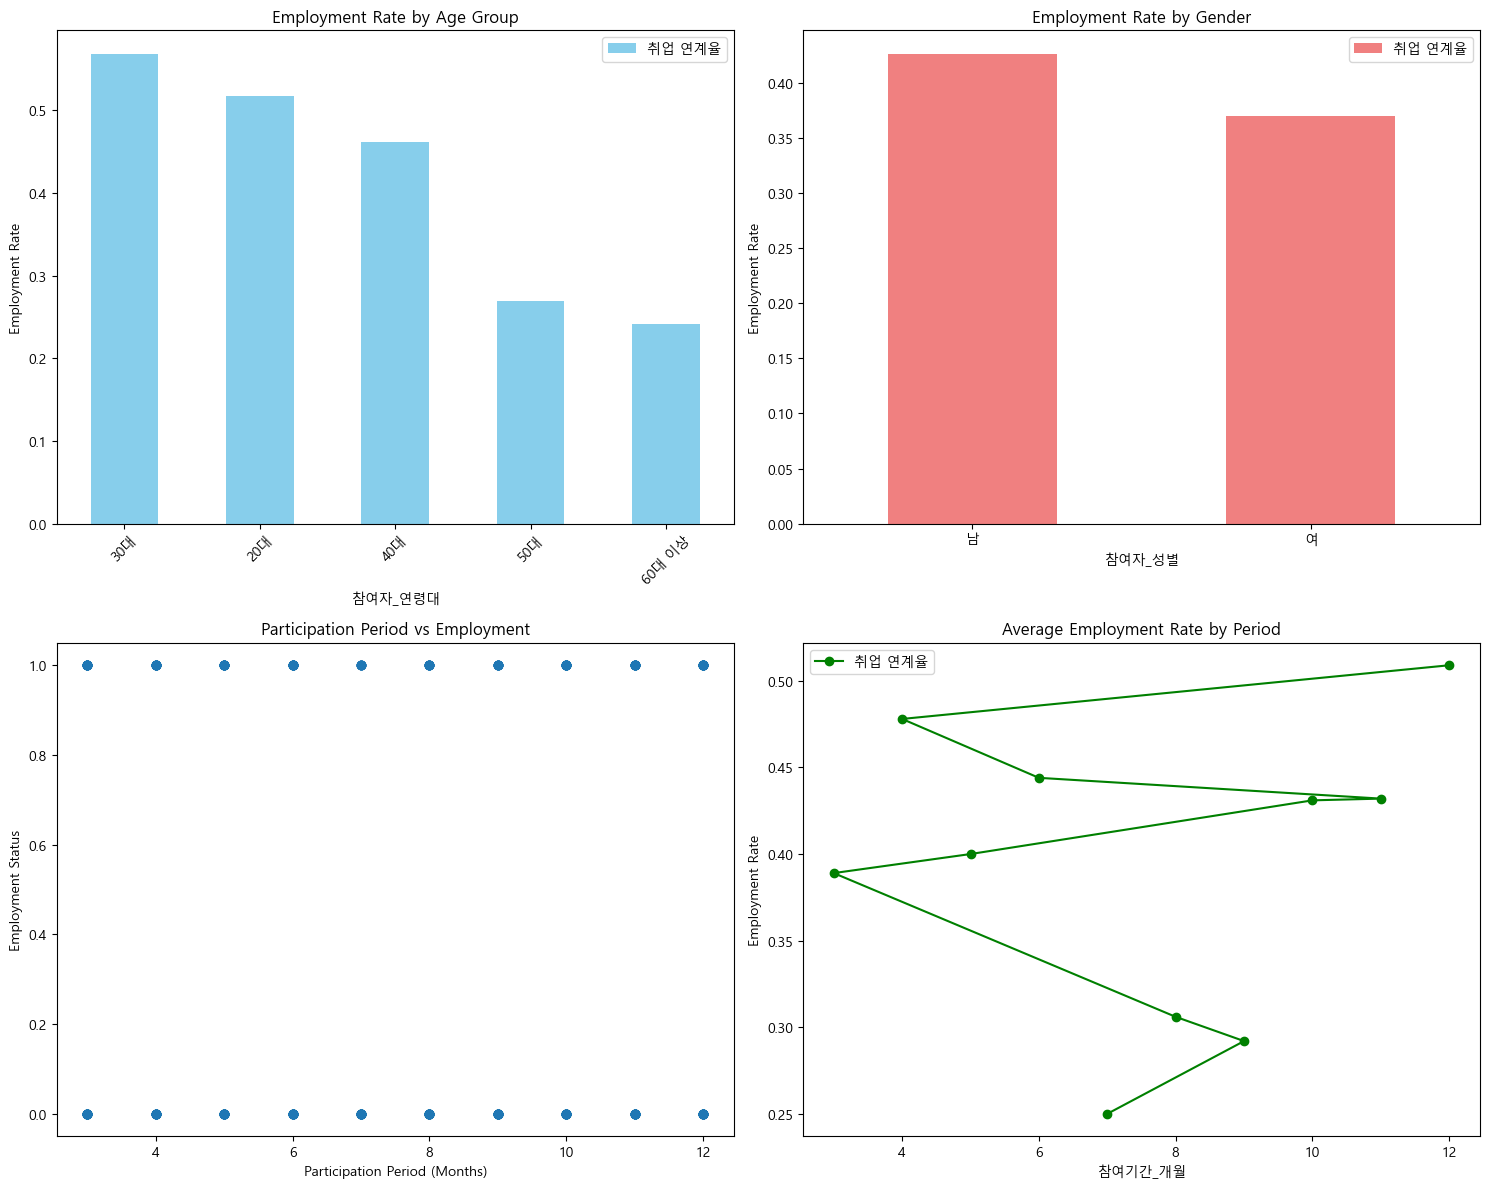

In [18]:
# 시각화: 그룹별 취업 연계율
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 연령대별 취업 연계율
age_employment.reset_index().plot(x='참여자_연령대', y='취업 연계율', kind='bar', 
                                  ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Employment Rate by Age Group', fontsize=12)
axes[0,0].set_ylabel('Employment Rate', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=45)

# 2. 성별 취업 연계율
gender_employment.reset_index().plot(x='참여자_성별', y='취업 연계율', kind='bar', 
                                     ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Employment Rate by Gender', fontsize=12)
axes[0,1].set_ylabel('Employment Rate', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=0)

# 3. 참여기간별 취업 연계율 (산점도)
axes[1,0].scatter(df['참여기간_개월'], df['취업_연계_여부'], alpha=0.6)
axes[1,0].set_xlabel('Participation Period (Months)', fontsize=10)
axes[1,0].set_ylabel('Employment Status', fontsize=10)
axes[1,0].set_title('Participation Period vs Employment', fontsize=12)

# 4. 참여기간별 평균 취업 연계율 (선 그래프)
period_employment.reset_index().plot(x='참여기간_개월', y='취업 연계율', 
                                     ax=axes[1,1], color='green', marker='o')
axes[1,1].set_title('Average Employment Rate by Period', fontsize=12)
axes[1,1].set_ylabel('Employment Rate', fontsize=10)

plt.tight_layout()
plt.show()

## 8. 종합 분석 결과

In [19]:
print("=" * 80)
print("공공일자리 참여자 취업 연계 분석 결과 요약")
print("=" * 80)

print("\n1. 모델 성능:")
print(f"   - 정확도: {accuracy:.3f}")
print(f"   - 정밀도: {precision:.3f}")
print(f"   - 재현율: {recall:.3f}")
print(f"   - F1-Score: {f1:.3f}")

print("\n2. 주요 영향 요인 (계수 기준):")
top_positive = coefficients[coefficients['계수'] > 0].head(3)
top_negative = coefficients[coefficients['계수'] < 0].head(3)

print("   [취업 연계 확률을 높이는 요인]")
for _, row in top_positive.iterrows():
    print(f"   - {row['특성']}: 계수 {row['계수']:.3f}, 오즈비 {row['오즈비']:.3f}")

print("   [취업 연계 확률을 낮추는 요인]")
for _, row in top_negative.iterrows():
    print(f"   - {row['특성']}: 계수 {row['계수']:.3f}, 오즈비 {row['오즈비']:.3f}")

print("\n3. 그룹별 취업 연계율:")
print("   [연령대별]")
for idx, row in age_employment.iterrows():
    print(f"   - {idx}: {row['취업 연계율']:.1%} ({row['취업 연계 수']:.0f}/{row['총 참여자 수']:.0f}명)")

print("   [성별]")
for idx, row in gender_employment.iterrows():
    print(f"   - {idx}: {row['취업 연계율']:.1%} ({row['취업 연계 수']:.0f}/{row['총 참여자 수']:.0f}명)")

print(f"\n4. 참여기간 영향:")
print(f"   - 참여기간과 취업 연계의 상관계수: {correlation:.3f}")
if correlation > 0:
    print("   - 참여기간이 길수록 취업 연계 확률이 높아짐")
else:
    print("   - 참여기간이 길수록 취업 연계 확률이 낮아짐")

print("\n=" * 80)

공공일자리 참여자 취업 연계 분석 결과 요약

1. 모델 성능:
   - 정확도: 0.580
   - 정밀도: 0.471
   - 재현율: 0.400
   - F1-Score: 0.432

2. 주요 영향 요인 (계수 기준):
   [취업 연계 확률을 높이는 요인]
   - 연령대_30대: 계수 0.663, 오즈비 1.941
   - 연령대_20대: 계수 0.544, 오즈비 1.723
   - 성별_남: 계수 0.120, 오즈비 1.127
   [취업 연계 확률을 낮추는 요인]
   - 연령대_60대 이상: 계수 -0.657, 오즈비 0.519
   - 연령대_50대: 계수 -0.625, 오즈비 0.535
   - 성별_여: 계수 -0.120, 오즈비 0.887

3. 그룹별 취업 연계율:
   [연령대별]
   - 30대: 56.8% (50/88명)
   - 20대: 51.7% (45/87명)
   - 40대: 46.2% (43/93명)
   - 50대: 26.9% (39/145명)
   - 60대 이상: 24.1% (21/87명)
   [성별]
   - 남: 42.6% (100/235명)
   - 여: 37.0% (98/265명)

4. 참여기간 영향:
   - 참여기간과 취업 연계의 상관계수: 0.021
   - 참여기간이 길수록 취업 연계 확률이 높아짐

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
